# ZOO faster than FOO

## Prepare

In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data

import torch.nn.utils.prune as prune

import numpy as np
import math
import os
import time
import matplotlib.pyplot as plt

from import_shelf import shelf
from shelf.models.transformer import VisionTransformer
from shelf.dataloaders.cifar import get_CIFAR10_dataset
from shelf.trainers import train, validate, train_zo

os.environ["CUDA_VISIBLE_DEVICES"]="MIG-60fed909-9539-55f4-9bab-e99df995d4a0"

In [2]:
### HYPERPARAMS ###

LEARNING_RATE = 1e-4
BATCH_SIZE = 512
IMAGE_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 10

MODEL_CONFIG = {
    "dim": 64,
    "depth": 4,
    "heads": 6,
    "mlp_dim": 256,
    "dropout": 0.1,
    "emb_dropout": 0.1,
}

META_CONFIG = {
    "dim": 64,
    "depth": 4,
    "heads": 1,
    "mlp_dim": 16,
    "dropout": 0.1,
    "emb_dropout": 0.1,
}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PATH_MODEL = './saves/incubate_vit/model.pth'
PATH_MODEL_ASSM = './saves/model_assembled.pth'
PATH_MODEL_META = './saves/model_meta.pth'

Files already downloaded and verified


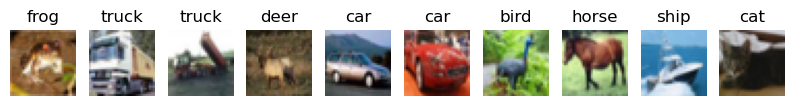

In [3]:
### DATA LOADING ###

train_loader, val_loader = get_CIFAR10_dataset(batch_size=BATCH_SIZE)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_loader.dataset.data[i])
    plt.title(classes[train_loader.dataset.targets[i]])
    plt.axis('off')

## Train Meta-Model

In [4]:
### MODEL ###

model_meta = VisionTransformer(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    **META_CONFIG
).to(DEVICE)

num_params = sum(p.numel() for p in model_meta.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 66826


In [5]:
### OTHERS ###

EPOCHS = 1

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_meta.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-5)

In [6]:
### TRAINING ###

for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_loader, model_meta, criterion, optimizer, epoch, verbose=False)
    val_acc, val_loss = validate(val_loader, model_meta, criterion, epoch, verbose=False)

    print(
        f"Epoch {epoch+1:3d}/{EPOCHS}, "
        f"LR: {scheduler.get_last_lr()[0]:.4e} | "
        f"Train Loss: {train_loss:.4f}, "
        f"Train Acc: {train_acc * 100:.2f}%, "
        f"Val Loss: {val_loss:.4f}, "
        f"Val Acc: {val_acc*100:.2f}%"
    )

    scheduler.step()


Epoch   1/1, LR: 1.0000e-04 | Train Loss: 2.2665, Train Acc: 15.27%, Val Loss: 2.1570, Val Acc: 20.17%


# Prune Model

In [7]:
for name, module in model_meta.transformer.named_modules():
    if isinstance(module, nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.99)

num_params = 0
model_state = model_meta.state_dict()

for name, param in model_meta.named_parameters():
    if 'weight_orig' in name:
        mask = model_state[name.replace('_orig', '_mask')]
        num_params += torch.sum(mask != 0).item()
    else:
        num_params += param.numel()

print(f"Number of parameters: {num_params}")

Number of parameters: 10054


In [8]:
val_acc, val_loss = validate(val_loader, model_meta, criterion, 0, verbose=False)

print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")


Val Loss: 2.3579, Val Acc: 10.32%


## Fine-Tune by ZOO


In [9]:
FT_EPOCHS = 10

optimizer = torch.optim.Adam(model_meta.parameters(), lr=LEARNING_RATE)

for epoch in range(FT_EPOCHS):
    train_log = {}
    train_acc, train_loss = train_zo(
        train_loader, model_meta, criterion, optimizer, epoch, 
        lr_max=1e-3, ge_type='paramwise', query=1,
        verbose=True, config=train_log
    )
    val_acc, val_loss = validate(val_loader, model_meta, criterion, epoch, verbose=True)

    print(
        f"Epoch {epoch+1:3d}/{FT_EPOCHS}, "
        f"LR: {train_log['avg_lr']:.5f}±{train_log['std_lr']:.5f} | "
        f"Train Loss: {train_loss:.4f}, "
        f"Train Acc: {train_acc * 100:.2f}%, "
        f"Val Loss: {val_loss:.4f}, "
        f"Val Acc: {val_acc*100:.2f}%"
    )


Epoch   1/10, LR: 0.00016±0.00036 | Train Loss: 2.3527, Train Acc: 10.14%, Val Loss: 2.3347, Val Acc: 11.23%


Epoch   2/10, LR: 0.00013±0.00032 | Train Loss: 2.3335, Train Acc: 10.71%, Val Loss: 2.3197, Val Acc: 12.90%


Epoch   3/10, LR: 0.00007±0.00024 | Train Loss: 2.3218, Train Acc: 11.76%, Val Loss: 2.3122, Val Acc: 13.95%


Epoch   4/10, LR: 0.00010±0.00029 | Train Loss: 2.3153, Train Acc: 12.42%, Val Loss: 2.3038, Val Acc: 15.18%


Epoch   5/10, LR: 0.00015±0.00035 | Train Loss: 2.3047, Train Acc: 14.20%, Val Loss: 2.2915, Val Acc: 16.14%


Epoch   6/10, LR: 0.00006±0.00022 | Train Loss: 2.2955, Train Acc: 15.56%, Val Loss: 2.2872, Val Acc: 16.44%


Epoch   7/10, LR: 0.00008±0.00025 | Train Loss: 2.2920, Train Acc: 15.74%, Val Loss: 2.2824, Val Acc: 16.67%


Epoch   8/10, LR: 0.00018±0.00037 | Train Loss: 2.2854, Train Acc: 16.15%, Val Loss: 2.2740, Val Acc: 16.59%


Epoch   9/10, LR: 0.00012±0.00031 | Train Loss: 2.2790, Train Acc: 16.28%, Val Loss: 2.2705, Val Acc: 16.68%


Epoch  10/10, LR: 0.00006±0.00022 | Train Loss: 2.2769, Train Acc: 16.33%, Val Loss: 2.2685, Val Acc: 16.73%
